<a href="https://colab.research.google.com/github/adenurchalisa/Capstone-Model/blob/main/model_prediksi_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import matplotlib.pyplot as plt

In [2]:
# 1. Mount Google Drive (jika di Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

file_path = '/content/drive/MyDrive/capstoneku/data_transaksi_advanced.csv'
df = pd.read_csv(file_path)
df['tanggal'] = pd.to_datetime(df['tanggal'])

In [4]:
# 2. Preprocessing Waktu
df = df.drop(columns=['rating', 'anomaly_flag', 'id_transaksi'])
df['bulan'] = df['tanggal'].dt.month
df['tahun'] = df['tanggal'].dt.year
df['hari'] = df['tanggal'].dt.day
df['hari_ke'] = df['tanggal'].dt.dayofweek
df['jam'] = pd.to_datetime(df['waktu'], format='%H:%M').dt.hour
df = df.drop(columns=['tanggal', 'waktu'])

In [5]:
# 3. Fitur Musiman/Event
df['is_ramadan'] = (
    ((df['tahun'] == 2022) & (df['bulan'] == 4)) |
    ((df['tahun'] == 2023) & (df['bulan'].isin([3, 4]))) |
    ((df['tahun'] == 2024) & (df['bulan'].isin([3, 4])))
).astype(int)

df['is_lebaran'] = (
    ((df['tahun'] == 2022) & (df['bulan'] == 5)) |
    ((df['tahun'] == 2023) & (df['bulan'] == 4)) |
    ((df['tahun'] == 2024) & (df['bulan'] == 4))
).astype(int)

df['is_libur_sekolah'] = df['bulan'].isin([6, 7]).astype(int)
df['is_akhir_tahun'] = (df['bulan'] == 12).astype(int)

In [6]:
# 4. Label Encoding Kategori
le_profil = LabelEncoder()
df['profil_enc'] = le_profil.fit_transform(df['profil'])
le_mp = LabelEncoder()
df['metode_pembayaran_enc'] = le_mp.fit_transform(df['metode_pembayaran'])
le_lokasi = LabelEncoder()
df['lokasi_enc'] = le_lokasi.fit_transform(df['lokasi'])

In [7]:
# 5. Filter Pengeluaran Saja
df_pengeluaran = df[df['tipe'] == 'keluar'].copy()

In [8]:
# 6. Agregasi Bulanan per User
agg = df_pengeluaran.groupby(['user_id', 'tahun', 'bulan']).agg(
    total_pengeluaran=('nominal', 'sum'),
    jumlah_transaksi=('nominal', 'count'),
    rata2_transaksi=('nominal', 'mean'),
    profil_enc=('profil_enc', 'first'),
    metode_pembayaran_enc=('metode_pembayaran_enc', lambda x: x.mode()[0] if len(x) else 0),
    lokasi_enc=('lokasi_enc', lambda x: x.mode()[0] if len(x) else 0)
).reset_index()
agg = agg.sort_values(['user_id', 'tahun', 'bulan'])

In [9]:
# 7. Fitur Derivatif Rolling/statistik
agg['pengeluaran_bulan_lalu'] = agg.groupby('user_id')['total_pengeluaran'].shift(1)
agg['rolling3_pengeluaran'] = agg.groupby('user_id')['total_pengeluaran'].rolling(window=3, min_periods=1).mean().shift(1).values
agg['rolling3_std'] = agg.groupby('user_id')['total_pengeluaran'].rolling(window=3, min_periods=1).std().shift(1).values
agg['rolling3_min'] = agg.groupby('user_id')['total_pengeluaran'].rolling(window=3, min_periods=1).min().shift(1).values
agg['rolling3_max'] = agg.groupby('user_id')['total_pengeluaran'].rolling(window=3, min_periods=1).max().shift(1).values
agg['trend_bulan'] = (agg['total_pengeluaran'] - agg['pengeluaran_bulan_lalu']) / (agg['pengeluaran_bulan_lalu'] + 1)
agg['target'] = agg.groupby('user_id')['total_pengeluaran'].shift(-1)

In [10]:
# 8. Fitur Musiman/Event di agg
agg['is_ramadan'] = (
    ((agg['tahun'] == 2022) & (agg['bulan'] == 4)) |
    ((agg['tahun'] == 2023) & (agg['bulan'].isin([3, 4]))) |
    ((agg['tahun'] == 2024) & (agg['bulan'].isin([3, 4])))
).astype(int)
agg['is_lebaran'] = (
    ((agg['tahun'] == 2022) & (agg['bulan'] == 5)) |
    ((agg['tahun'] == 2023) & (agg['bulan'] == 4)) |
    ((agg['tahun'] == 2024) & (agg['bulan'] == 4))
).astype(int)
agg['is_libur_sekolah'] = agg['bulan'].isin([6, 7]).astype(int)
agg['is_akhir_tahun'] = (agg['bulan'] == 12).astype(int)

In [11]:
# 9. Drop NA Baris
agg = agg.dropna(subset=[
    'target', 'pengeluaran_bulan_lalu', 'rolling3_pengeluaran',
    'rolling3_std', 'rolling3_min', 'rolling3_max', 'trend_bulan'
]).reset_index(drop=True)

In [12]:
# 10. Split Train/Test
train = agg[agg['tahun'] < 2024]
test = agg[agg['tahun'] == 2024]

In [13]:
# 11. Daftar Fitur Full
fitur = [
    'total_pengeluaran', 'jumlah_transaksi', 'rata2_transaksi',
    'profil_enc', 'metode_pembayaran_enc', 'lokasi_enc', 'bulan',
    'pengeluaran_bulan_lalu', 'rolling3_pengeluaran',
    'rolling3_std', 'rolling3_min', 'rolling3_max', 'trend_bulan',
    'is_ramadan', 'is_lebaran', 'is_libur_sekolah', 'is_akhir_tahun'
]

X_train = train[fitur]
y_train = train['target']
X_test = test[fitur]
y_test = test['target']

In [14]:
# 12. Target Log Transform
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [15]:
# 13. Hyperparameter XGBoost
param_grid = {
    'n_estimators': [80, 100, 120, 140, 160],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.08, 0.1, 0.12, 0.15],
    'subsample': [0.5, 0.6, 0.7],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [3, 5, 7, 10],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2, 3]
}
xgb_base = XGBRegressor(random_state=42, n_jobs=-1)
tscv = TimeSeriesSplit(n_splits=3)
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=60,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train_log)
print("Best parameters found:")
print(random_search.best_params_)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
Best parameters found:
{'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.12, 'gamma': 7, 'colsample_bytree': 0.9}


In [16]:
# 14. Evaluasi Model XGBoost
best_model = random_search.best_estimator_
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
mask = y_test > 200000
if mask.sum() > 0:
    mape_200k = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100
    print(f"MAPE (target > 200k): {mape_200k:.2f}%")
else:
    print("Tidak ada data target > 200 ribu.")

MAE: 5940091.78
RMSE: 10220430.87
MAPE: 391.71%
MAPE (target > 200k): 146.76%


In [17]:
# 15. Baseline (Naive)
baseline_pred = X_test['pengeluaran_bulan_lalu']
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_mape = np.mean(np.abs((y_test - baseline_pred) / y_test)) * 100
print(f"Baseline MAE: {baseline_mae:.2f}, Baseline MAPE: {baseline_mape:.2f}%")

Baseline MAE: 8093284.09, Baseline MAPE: 674.36%


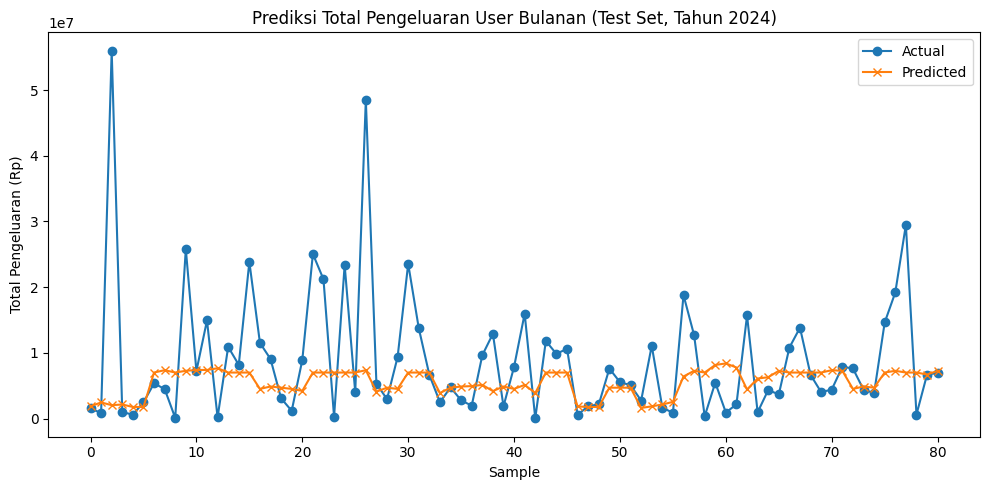

In [18]:
# 16. Visualisasi Prediksi vs Aktual
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.legend()
plt.title('Prediksi Total Pengeluaran User Bulanan (Test Set, Tahun 2024)')
plt.xlabel('Sample')
plt.ylabel('Total Pengeluaran (Rp)')
plt.tight_layout()
plt.show()

10 User dengan MAPE tertinggi:
user_id
U013    2507.493641
U003    2201.951462
U004    1034.349046
U018     682.917378
U007     661.457596
U025     348.192874
U019     297.779866
U020     224.947877
U002     113.533573
U006     110.321294
Name: mape, dtype: float64


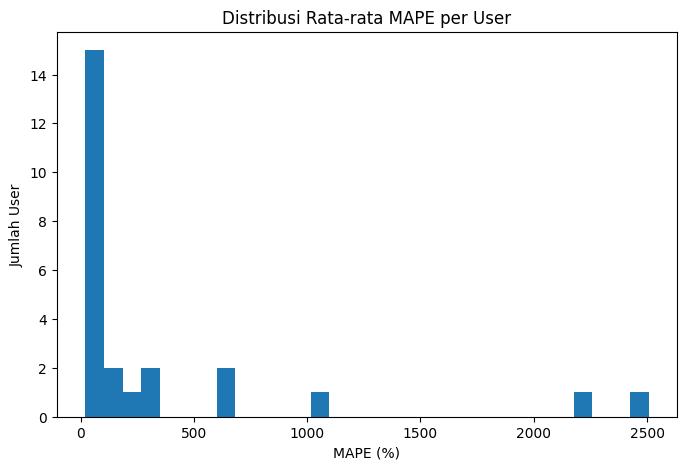

In [19]:
# 17. Analisis Error Per User
df_eval = test[['user_id','bulan','tahun']].copy()
df_eval["actual"] = y_test.values
df_eval["pred"] = y_pred
df_eval["abs_error"] = abs(df_eval["actual"] - df_eval["pred"])
df_eval["mape"] = 100 * abs(df_eval["actual"] - df_eval["pred"]) / (df_eval["actual"] + 1e-8)

user_error = df_eval.groupby("user_id")["mape"].mean().sort_values(ascending=False)
print("10 User dengan MAPE tertinggi:")
print(user_error.head(10))

plt.figure(figsize=(8,5))
user_error.plot(kind="hist", bins=30)
plt.title("Distribusi Rata-rata MAPE per User")
plt.xlabel("MAPE (%)")
plt.ylabel("Jumlah User")
plt.show()

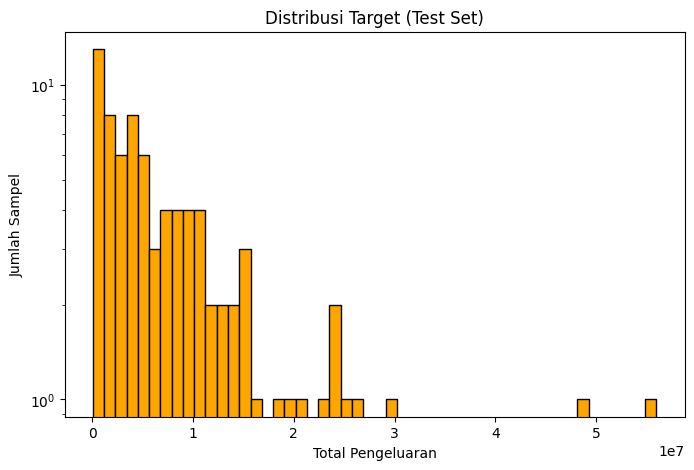

Target terbesar:
 24     5.598610e+07
202    4.852469e+07
605    2.948892e+07
97     2.580193e+07
175    2.504739e+07
Name: target, dtype: float64
Target terkecil:
 328     39424.32
74     106025.76
100    186390.72
177    274453.92
454    343621.44
Name: target, dtype: float64


In [20]:
# 18. Analisis Outlier Target
plt.figure(figsize=(8,5))
plt.hist(y_test, bins=50, color='orange', edgecolor='k')
plt.title('Distribusi Target (Test Set)')
plt.xlabel('Total Pengeluaran')
plt.ylabel('Jumlah Sampel')
plt.yscale('log')
plt.show()
print("Target terbesar:\n", y_test.sort_values(ascending=False).head())
print("Target terkecil:\n", y_test.sort_values().head())

In [21]:
# 19. Error per Event
for event in ['is_ramadan', 'is_lebaran', 'is_libur_sekolah', 'is_akhir_tahun']:
    event_mask = test[event].values == 1
    print(f"MAPE rata-rata {event}=1: {np.mean(np.abs((y_test[event_mask] - y_pred[event_mask]) / y_test[event_mask])) * 100:.2f}%")
    print(f"MAPE rata-rata {event}=0: {np.mean(np.abs((y_test[~event_mask] - y_pred[~event_mask]) / y_test[~event_mask])) * 100:.2f}%")


MAPE rata-rata is_ramadan=1: 854.83%
MAPE rata-rata is_ramadan=0: 104.58%
MAPE rata-rata is_lebaran=1: 2795.16%
MAPE rata-rata is_lebaran=0: 199.44%
MAPE rata-rata is_libur_sekolah=1: nan%
MAPE rata-rata is_libur_sekolah=0: 391.71%
MAPE rata-rata is_akhir_tahun=1: nan%
MAPE rata-rata is_akhir_tahun=0: 391.71%


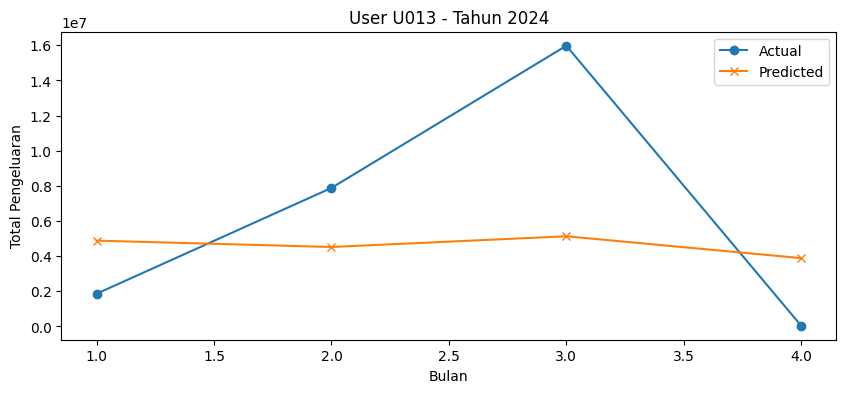

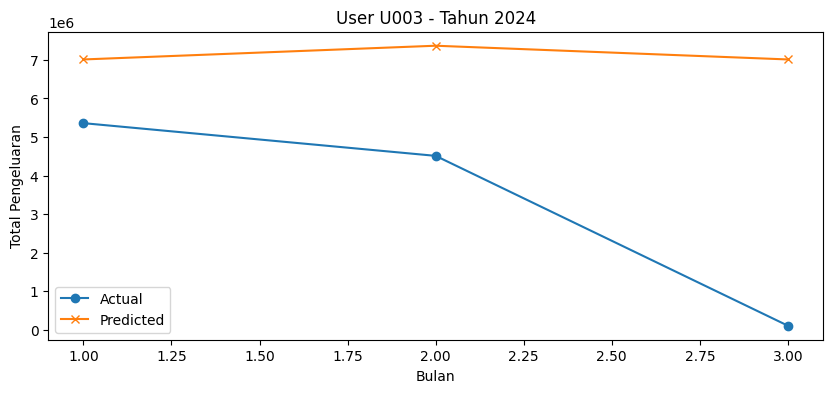

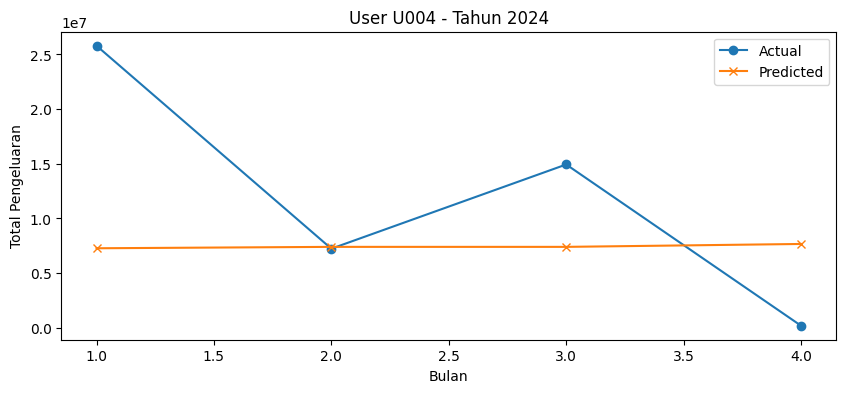

In [22]:
# 20. Visualisasi Prediksi vs Aktual per User dengan Error Tertinggi
for u in user_error.head(3).index:
    temp = df_eval[df_eval["user_id"] == u]
    plt.figure(figsize=(10,4))
    plt.plot(temp["bulan"], temp["actual"], label="Actual", marker='o')
    plt.plot(temp["bulan"], temp["pred"], label="Predicted", marker='x')
    plt.title(f"User {u} - Tahun 2024")
    plt.xlabel("Bulan")
    plt.ylabel("Total Pengeluaran")
    plt.legend()
    plt.show()

10 User dengan MAPE tertinggi:
user_id
U013    2507.493641
U003    2201.951462
U004    1034.349046
U018     682.917378
U007     661.457596
U025     348.192874
U019     297.779866
U020     224.947877
U002     113.533573
U006     110.321294
Name: mape, dtype: float64


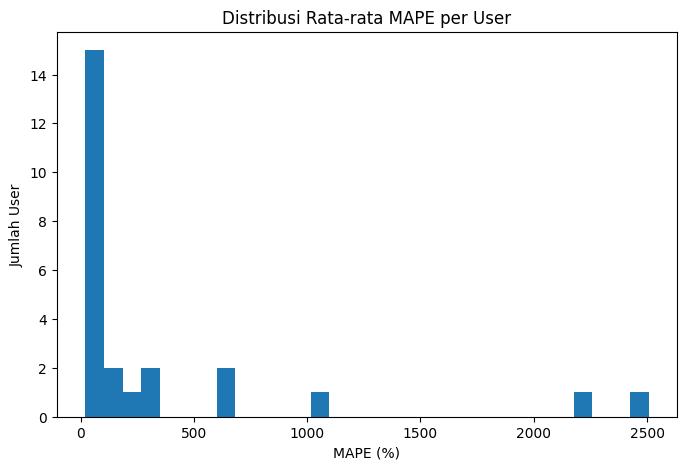

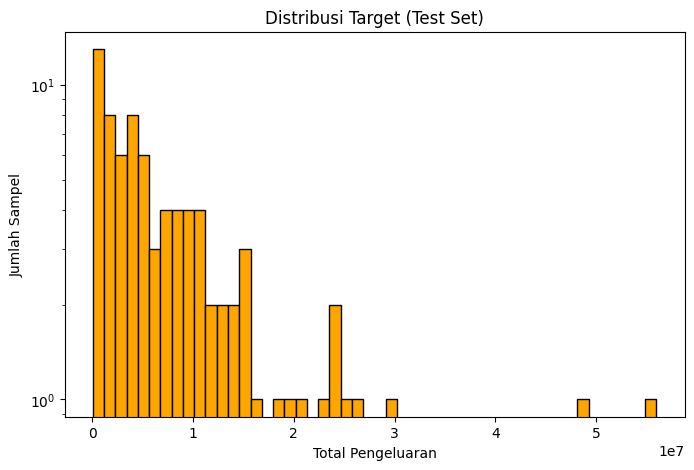

Target terbesar:
 24     5.598610e+07
202    4.852469e+07
605    2.948892e+07
97     2.580193e+07
175    2.504739e+07
Name: target, dtype: float64
Target terkecil:
 328     39424.32
74     106025.76
100    186390.72
177    274453.92
454    343621.44
Name: target, dtype: float64
MAPE rata-rata is_ramadan=1: 854.83%
MAPE rata-rata is_ramadan=0: 104.58%
MAPE rata-rata is_lebaran=1: 2795.16%
MAPE rata-rata is_lebaran=0: 199.44%
MAPE rata-rata is_libur_sekolah=1: nan%
MAPE rata-rata is_libur_sekolah=0: 391.71%
MAPE rata-rata is_akhir_tahun=1: nan%
MAPE rata-rata is_akhir_tahun=0: 391.71%


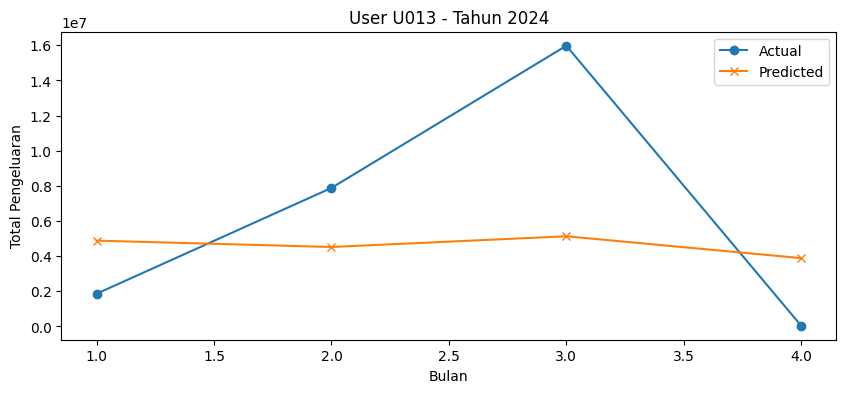

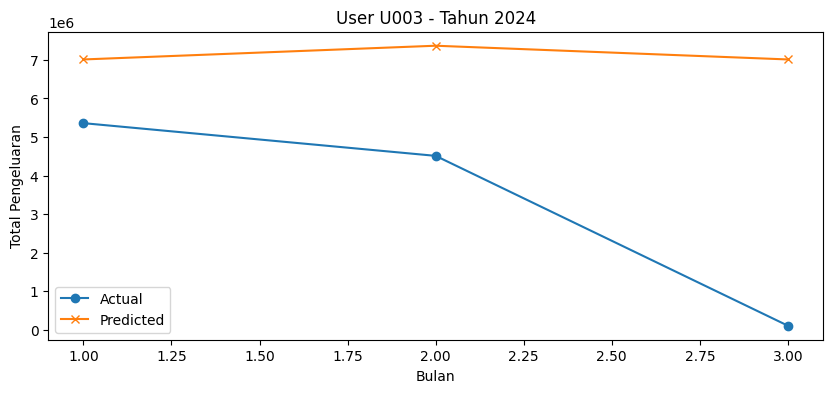

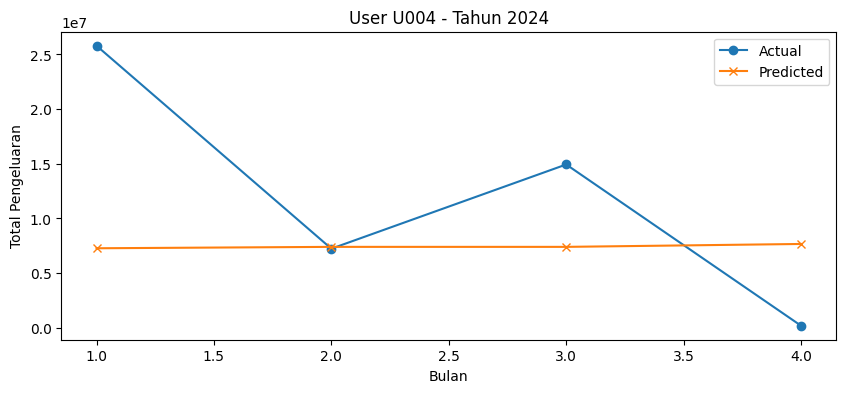

In [23]:
# --- Analisis Error Per User ---
df_eval = test[['user_id','bulan','tahun']].copy()
df_eval["actual"] = y_test.values
df_eval["pred"] = y_pred
df_eval["abs_error"] = abs(df_eval["actual"] - df_eval["pred"])
df_eval["mape"] = 100 * abs(df_eval["actual"] - df_eval["pred"]) / (df_eval["actual"] + 1e-8)

user_error = df_eval.groupby("user_id")["mape"].mean().sort_values(ascending=False)
print("10 User dengan MAPE tertinggi:")
print(user_error.head(10))

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
user_error.plot(kind="hist", bins=30)
plt.title("Distribusi Rata-rata MAPE per User")
plt.xlabel("MAPE (%)")
plt.ylabel("Jumlah User")
plt.show()

# --- Analisis Outlier Target ---
plt.figure(figsize=(8,5))
plt.hist(y_test, bins=50, color='orange', edgecolor='k')
plt.title('Distribusi Target (Test Set)')
plt.xlabel('Total Pengeluaran')
plt.ylabel('Jumlah Sampel')
plt.yscale('log')
plt.show()
print("Target terbesar:\n", y_test.sort_values(ascending=False).head())
print("Target terkecil:\n", y_test.sort_values().head())

# --- Error per Event ---
for event in ['is_ramadan', 'is_lebaran', 'is_libur_sekolah', 'is_akhir_tahun']:
    event_mask = test[event].values == 1
    print(f"MAPE rata-rata {event}=1: {np.mean(np.abs((y_test[event_mask] - y_pred[event_mask]) / y_test[event_mask])) * 100:.2f}%")
    print(f"MAPE rata-rata {event}=0: {np.mean(np.abs((y_test[~event_mask] - y_pred[~event_mask]) / y_test[~event_mask])) * 100:.2f}%")

# --- Visualisasi Prediksi vs Aktual per User dengan Error Tertinggi ---
for u in user_error.head(3).index:
    temp = df_eval[df_eval["user_id"] == u]
    plt.figure(figsize=(10,4))
    plt.plot(temp["bulan"], temp["actual"], label="Actual", marker='o')
    plt.plot(temp["bulan"], temp["pred"], label="Predicted", marker='x')
    plt.title(f"User {u} - Tahun 2024")
    plt.xlabel("Bulan")
    plt.ylabel("Total Pengeluaran")
    plt.legend()
    plt.show()

User outlier (MAPE > 500%): ['U013', 'U003', 'U004', 'U018', 'U007']
Tanpa user outlier:
MAE: 5451620.48
RMSE: 10410481.67
MAPE: 100.32%
Baseline MAE: 7462828.44, Baseline MAPE: 169.17%


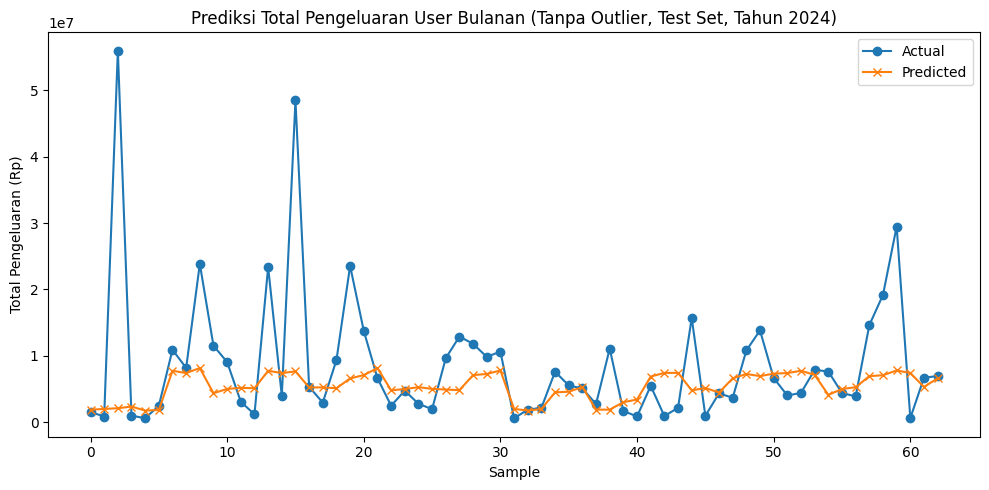

10 User dengan MAPE tertinggi (setelah exclude outlier):
user_id
U025    376.652160
U019    261.155311
U020    172.466575
U006    126.748432
U017    121.814037
U002    118.674885
U012     89.021001
U015     86.709124
U001     84.291441
U008     79.020191
Name: mape, dtype: float64


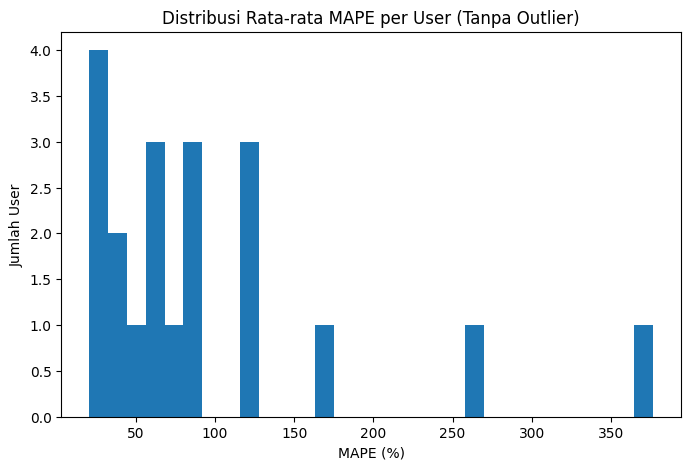

In [24]:
# 1. Identifikasi user dengan error ekstrem (misal MAPE > 500%)
threshold = 500
outlier_users = user_error[user_error > threshold].index.tolist()
print(f"User outlier (MAPE > {threshold}%): {outlier_users}")

# 2. Exclude user outlier dari data train & test
train_clean = train[~train['user_id'].isin(outlier_users)].copy()
test_clean = test[~test['user_id'].isin(outlier_users)].copy()

# 3. Re-define fitur & target
X_train_clean = train_clean[fitur]
y_train_clean = train_clean['target']
X_test_clean = test_clean[fitur]
y_test_clean = test_clean['target']

# 4. Log transform target
y_train_clean_log = np.log1p(y_train_clean)
y_test_clean_log = np.log1p(y_test_clean)

# 5. Train ulang model (pakai best_params dari random_search sebelumnya)
model_clean = XGBRegressor(
    subsample=0.7, reg_lambda=1, reg_alpha=0, n_estimators=100,
    max_depth=6, learning_rate=0.12, gamma=7, colsample_bytree=0.9,
    random_state=42, n_jobs=-1
)
model_clean.fit(X_train_clean, y_train_clean_log)

# 6. Prediksi & evaluasi ulang
y_pred_clean_log = model_clean.predict(X_test_clean)
y_pred_clean = np.expm1(y_pred_clean_log)
mae_clean = mean_absolute_error(y_test_clean, y_pred_clean)
rmse_clean = np.sqrt(mean_squared_error(y_test_clean, y_pred_clean))
mape_clean = np.mean(np.abs((y_test_clean - y_pred_clean) / y_test_clean)) * 100
print(f"Tanpa user outlier:")
print(f"MAE: {mae_clean:.2f}")
print(f"RMSE: {rmse_clean:.2f}")
print(f"MAPE: {mape_clean:.2f}%")

# 7. Bandingkan dengan baseline naive
baseline_pred_clean = X_test_clean['pengeluaran_bulan_lalu']
baseline_mae_clean = mean_absolute_error(y_test_clean, baseline_pred_clean)
baseline_mape_clean = np.mean(np.abs((y_test_clean - baseline_pred_clean) / y_test_clean)) * 100
print(f"Baseline MAE: {baseline_mae_clean:.2f}, Baseline MAPE: {baseline_mape_clean:.2f}%")

# 8. Visualisasi ulang
plt.figure(figsize=(10,5))
plt.plot(y_test_clean.values, label='Actual', marker='o')
plt.plot(y_pred_clean, label='Predicted', marker='x')
plt.legend()
plt.title('Prediksi Total Pengeluaran User Bulanan (Tanpa Outlier, Test Set, Tahun 2024)')
plt.xlabel('Sample')
plt.ylabel('Total Pengeluaran (Rp)')
plt.tight_layout()
plt.show()

# 9. Analisis error per user (setelah exclude outlier)
df_eval_clean = test_clean[['user_id','bulan','tahun']].copy()
df_eval_clean["actual"] = y_test_clean.values
df_eval_clean["pred"] = y_pred_clean
df_eval_clean["abs_error"] = abs(df_eval_clean["actual"] - df_eval_clean["pred"])
df_eval_clean["mape"] = 100 * abs(df_eval_clean["actual"] - df_eval_clean["pred"]) / (df_eval_clean["actual"] + 1e-8)
user_error_clean = df_eval_clean.groupby("user_id")["mape"].mean().sort_values(ascending=False)
print("10 User dengan MAPE tertinggi (setelah exclude outlier):")
print(user_error_clean.head(10))

plt.figure(figsize=(8,5))
user_error_clean.plot(kind="hist", bins=30)
plt.title("Distribusi Rata-rata MAPE per User (Tanpa Outlier)")
plt.xlabel("MAPE (%)")
plt.ylabel("Jumlah User")
plt.show()